![Caribbeans for Climate]('/home/jovyan/CFC-cookoff2024/CFC-extreme-weather-cookbook/CFC_logo.PNG')

<h1 style="text-align: center;">Caribbeans for Climate:</h>
<h1 style='text-align: center;'>Understanding extreme weather variability in the Caribbean region</h1>

---

## Overview
Extreme weather events, both atmospheric and oceanic, are increasing in frequency and intensity as a consequence of anthropogenic warming. The processes responsible for such events and their impacts on Caribbean lives remain to be well understood. Our Caribbeans for Climate community (a community of Caribbean-identified climate scientists, oceanographers, and practitioners) have created a cookbook analyzing Caribbean atmospheric and oceanic extreme weather variability from 1850-2015, using Coupled Model Intercomparison Project Phase 6 (CMIP6) data. In this notebook, we execute basic statistical analysis to investigate the linkages between extreme atmospheric and oceanic heat-related events and the possible causes behind them.


1. Locate times when sea surface temperatures exceeded the 99th percentile threshold (MHW events)
1. Timeseries of ENSO 3.4 index overlaid on top of MHW events
1. Run basic statistics to determine any correlation between the aforementioned metrics

## Prerequisites
Some relavent knowledge on how to use certain packages (e.g. `xarray`, `matplotlib`) would be helpful to you in understanding this tutorial. If you need a refresher on how to employ these packages please refer to the [Pythia Foundations](https://foundations.projectpythia.org/landing-page.html) page. Also, please refer to the Project Pythia's [CMIP6 cookbook](https://projectpythia.org/cmip6-cookbook/README.html) page to familiarize yourself on how to ingest CMIP6 data.


| Concepts | Importance | Notes |
| --- | --- | --- |
| [CMIP6 data structure](https://projectpythia.org/cmip6-cookbook/README.html) | Necessary | Familiarity with query techniques|
| [Xarray](https://foundations.projectpythia.org/core/xarray.html) | Necessary | Familiarity with manipulating data structure|
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Helpful|
| Project management | Helpful | |

- **Time to learn**: estimate in minutes. For a rough idea, use 5 mins per subsection, 10 if longer; add these up for a total. Safer to round up and overestimate.
- **System requirements**:
    - Populate with any system, version, or non-Python software requirements if necessary
    - Otherwise use the concepts table above and the Imports section below to describe required packages as necessary
    - If no extra requirements, remove the **System requirements** point altogether

---

## Pip install `regionmask` and `xmip` packages into current environment

In [2]:
!pip install git+https://github.com/mathause/regionmask.git

  Cloning https://github.com/mathause/regionmask.git to /tmp/pip-req-build-2cr33sip
  Running command git clone --filter=blob:none --quiet https://github.com/mathause/regionmask.git /tmp/pip-req-build-2cr33sip
  Resolved https://github.com/mathause/regionmask.git to commit 8fa448e1ae9131ecb028b52ce3740d3627d8fe75
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for regionmask: filename=regionmask-0.9.0.post1.dev95+g8fa448e-py3-none-any.whl size=68020 sha256=01b64382bca02fa9df8f8ce8f0e9a0a4ae284181d908e34eac603c65e48cf5db
  Stored in directory: /tmp/pip-ephem-wheel-cache-ir618ba8/wheels/12/3c/e1/f1c2864aa8015b011d0c6dca10f004441dd966f8b80b6e0583
Successfully built regionmask


In [3]:
!pip install git+https://github.com/jbusecke/xmip.git

  Cloning https://github.com/jbusecke/xmip.git to /tmp/pip-req-build-tbbtazrc
  Running command git clone --filter=blob:none --quiet https://github.com/jbusecke/xmip.git /tmp/pip-req-build-tbbtazrc
  Resolved https://github.com/jbusecke/xmip.git to commit aff665950556abc1bdbae521c308a86f9ef8899a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached xgcm-0.6.1-py3-none-any.whl.metadata (6.0 kB)
Using cached xgcm-0.6.1-py3-none-any.whl (60 kB)
  Created wheel for xmip: filename=xmip-0.7.3.dev20+gaff6659-py3-none-any.whl size=58791 sha256=a9e1f74e23b7ecb7b975453cc32b6cec4983fa4b375c42eff9fa923c89e8eeb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-d7n1k7g6/wheels/cc/cb/e0/c0e3e2261ea5177d2f86070a483c40d9c878e6dd2e14a7f824
Successfully built xmip
  Attempting uninstall: xgcm
    Found existing installation: xgcm 0.8.1
    Uninstalling xgcm-0.8.1:
      Successfully uninstalled xgcm-0.8.1
  A

To initiate your ```Client```, navigate to the ```Dask```![<Dask>](dask_icon_v2.ico "Dask logo") tab in the far-left sidebar and click on the `+New` button in the lower left of the sidebar window (you can `Scale` to 8 workers to make the computation faster). Once the cluster is active, a `<>` button will appear left of the `Scale` button . Click on it and it will paste a cell with the Client code (like the one below) - run that and delete this old cell. Click on the `Launch dashboard in JupyterLab` button and the Task Stream, Workers Memory and Progress windows will open. In order to get them to render you have to replace `tcp://127.0.0.1:` with `proxy` in the searchbar at the top of the sidebar window

In [40]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 14.84 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44137,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 14.84 GiB
Comm: tcp://127.0.0.1:35347,Total threads: 1
Dashboard: http://127.0.0.1:45521/status,Memory: 3.71 GiB
Nanny: tcp://127.0.0.1:35771,


## Imports

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import regionmask  
from xmip.preprocessing import combined_preprocessing
from xmip.regionmask import merged_mask
from xgcm import Grid
import cmocean as cm
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

## Extreme SSTs

Marine heatwaves (MHWs) are characterized by extremely warm ocean temperatures that can span thousands of kilometers and last from days to months (Holbrook et al., 2019). Generally, they are defined as a MHW event when sea surface temperature (SST) exceed a certain threshold (typically, the 90th percentile threshold), and lasts for ≥5 consecutive days. These events can be devastating to marine life and the people that depend on maritime regions for sustenance and economy; such as fisheries and tribal communities. Despite their societal importance, however, a comprehensive understanding of the physical mechanisms driving MHWs in current and future climates does not yet exist. 

In this section, we will look at SST data from 2000-present and identify times when SST anomalies are within the 99th percentile and last for ≥10 days. These will be marked as extreme MHW events and help us better identify any potential correlative relationship between extreme SSTs and hurricane incidences. 

> Holbrook, Neil J., Hillary A. Scannell, Alexander Sen Gupta, Jessica A. Benthuysen, Ming Feng, Eric C. J. Oliver, Lisa V. Alexander, et al. “A Global Assessment of Marine Heatwaves and Their Drivers.” Nature Communications 10, no. 1 (June 14, 2019): 2624. https://doi.org/10.1038/s41467-019-10206-z.

### Load in the data

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [5]:
df_tos = df.query("table_id == 'Oday' & variable_id == 'tos' & experiment_id == 'historical'" + 
                  "& institution_id == 'NOAA-GFDL' & source_id == 'GFDL-CM4'")
df_tos

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
9445,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gr,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701
9446,CMIP,NOAA-GFDL,GFDL-CM4,historical,r1i1p1f1,Oday,tos,gn,gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...,NaN,20180701


In [6]:
#choose native grid
np.unique(df_tos['zstore'])

array(['gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gn/v20180701/',
       'gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gr/v20180701/'],
      dtype=object)

In [7]:
# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_tos['zstore'].values[-1]
print(zstore)

# create a mutable-mapping-style interface to the store
mapper = fsspec.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/historical/r1i1p1f1/Oday/tos/gn/v20180701/


<xarray.Dataset> Size: 375GB
Dimensions:    (bnds: 2, y: 1080, x: 1440, vertex: 4, time: 60225)
Coordinates:
  * bnds       (bnds) float64 16B 1.0 2.0
    lat        (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds   (y, x, vertex) float32 25MB dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon        (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds   (y, x, vertex) float32 25MB dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time       (time) object 482kB 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
    time_bnds  (time, bnds) object 964kB dask.array<chunksize=(30113, 1), meta=np.ndarray>
  * x          (x) float64 12kB -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * y          (y) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Dimensions without coordinates: vertex
Data variables:
    tos        (time, y, x) float32 375GB dask.array<chunksize=(18, 1080, 1440), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  36500.0
    comment:                <null ref>
    ...                     ...
    variable_id:            tos
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-11-16;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/e3b86300-29b2-4220-97ce-40fa504858e5...
    version_id:             v20180701

### Define the Caribbean Sea & Gulf of Mexico region

<GeoAxes: >

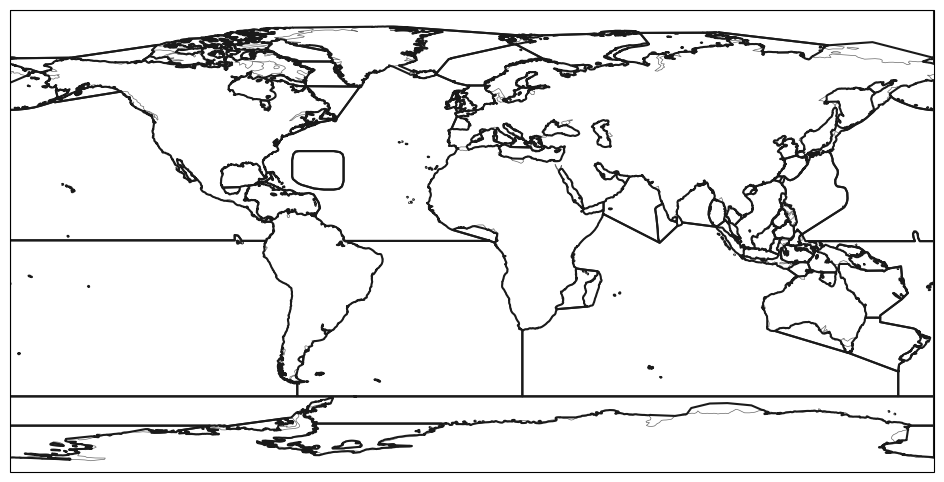

In [8]:
# load ocean basin data
basins = regionmask.defined_regions.natural_earth_v4_1_0.ocean_basins_50
basins.plot(add_ocean=False, add_label=False)

In [9]:
basin_mask = merged_mask(basins, ds[['lat', 'lon']])

/srv/conda/envs/notebook/lib/python3.11/site-packages/regionmask/core/mask.py:178: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


In [10]:
basin_mask

<xarray.DataArray 'mask' (y: 1080, x: 1440)> Size: 12MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    lat      (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon      (y, x) float32 6MB dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * x        (x) float64 12kB -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y        (y) float64 9kB -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95

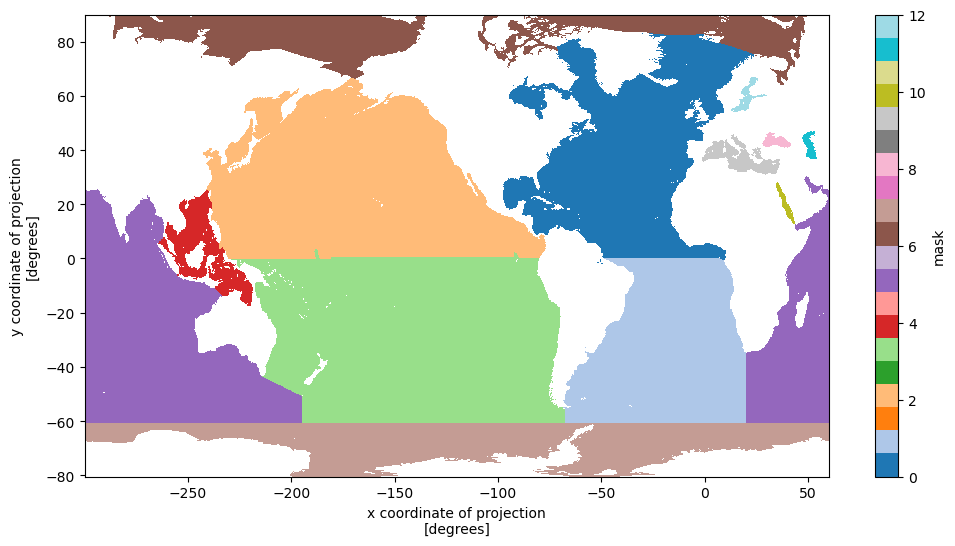

In [11]:
basin_mask.plot(cmap='tab20')

In [12]:
natl = 0
sst = ds.tos.where(basin_mask==natl)
carib = dict(x=slice(-98, -55), y=slice(8, 31), time=slice('1980', '2015'))
csst_unchunked = sst.sel(**carib)

In [13]:
csst = csst_unchunked.chunk({'time':-1, 'x':1,'y':1}).load()

In [14]:
csst

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 846MB
array([[[      nan,       nan,       nan, ..., 25.8405  , 25.837206,
         25.840914],
        [      nan,       nan,       nan, ..., 25.810337, 25.781202,
         25.783344],
        [      nan,       nan,       nan, ..., 25.795334, 25.74435 ,
         25.726683],
        ...,
        [      nan,       nan,       nan, ..., 19.91767 , 19.753414,
         19.353695],
        [      nan,       nan,       nan, ..., 19.668154, 19.469423,
         19.149704],
        [      nan,       nan,       nan, ..., 19.434666, 19.236498,
         19.017475]],

       [[      nan,       nan,       nan, ..., 25.85912 , 25.85692 ,
         25.86652 ],
        [      nan,       nan,       nan, ..., 25.819614, 25.79908 ,
         25.821692],
        [      nan,       nan,       nan, ..., 25.78365 , 25.73449 ,
         25.756374],
...
        [      nan,       nan,       nan, ..., 21.318853, 21.47445 ,
         21.460293],
        [      nan,       nan,       nan, ..., 21.11503 , 21.28229 ,
         21.252943],
        [      nan,       nan,       nan, ..., 20.638948, 20.861607,
         20.986332]],

       [[      nan,       nan,       nan, ..., 26.682354, 26.65766 ,
         26.601227],
        [      nan,       nan,       nan, ..., 26.675678, 26.650387,
         26.605356],
        [      nan,       nan,       nan, ..., 26.662418, 26.64014 ,
         26.600674],
        ...,
        [      nan,       nan,       nan, ..., 21.230621, 21.442247,
         21.452328],
        [      nan,       nan,       nan, ..., 21.071938, 21.265345,
         21.223864],
        [      nan,       nan,       nan, ..., 20.654604, 20.853203,
         20.919558]]], dtype=float32)
Coordinates:
    lat      (y, x) float32 66kB 8.222 8.222 8.222 8.222 ... 30.89 30.89 30.89
    lon      (y, x) float32 66kB -97.88 -97.62 -97.38 ... -56.38 -56.12 -55.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    Shutdown cluster, you don't need it after loading in the data. Also, the kernel crashes in the cell computing the 99th quantile with an active cluster.
</div>

In [41]:
client.close()

## Plot timeseries

In [15]:
from scipy.stats import linregress
lr = linregress(np.arange(0,12775), csst.mean(['x', 'y']).fillna(0.))
trend = (lr[0]*np.arange(0, 12775) + lr[1])

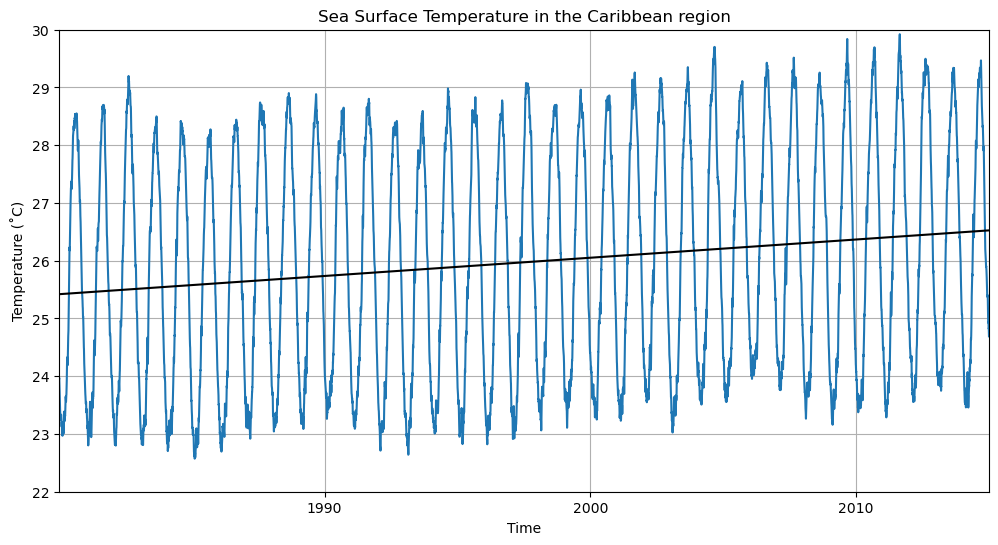

In [16]:
csst.mean(['x', 'y']).plot()
plt.plot(csst.time, trend, color='k')
plt.ylim(22, 30)
plt.xlim(csst.time[0].values, csst.time[-1].values)
plt.xlabel('Time')
plt.ylabel('Temperature (˚C)')
plt.title('Sea Surface Temperature in the Caribbean region')
plt.grid();

## Find the 99th percentile SST

In [17]:
sst99 = csst.quantile(0.99)

In [18]:
sst99.values

array(30.41907501)

## Meet the conditions: above 30.4 ˚C and >10 days

In [19]:
from scipy.ndimage import label
import flox

def _consecutive_mask(mask):
    labels, _ = label(mask, structure=np.array([1, 1, 1]))

    counts, _ = flox.groupby_reduce(labels, labels, func="count")
    counts[0] = 0
    return counts[labels]

def consecutive_mask(mask):
    return xr.apply_ufunc(
        _consecutive_mask,
        mask,
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=["uint16"],
    )

group_lengths = consecutive_mask(csst >= 30.4)
longer_than_10_days = group_lengths >= 10
mhws = csst.where(longer_than_10_days)
time_series = csst.where(longer_than_10_days).mean(["x", "y"])

In [20]:
mhws

<xarray.DataArray 'tos' (time: 12775, y: 98, x: 169)> Size: 846MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    lat      (y, x) float32 66kB 8.222 8.222 8.222 8.222 ... 30.89 30.89 30.89
    lon      (y, x) float32 66kB -97.88 -97.62 -97.38 ... -56.38 -56.12 -55.88
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00
  * x        (x) float64 1kB -97.84 -97.58 -97.33 -97.08 ... -55.75 -55.5 -55.25
  * y        (y) float64 784B 8.222 8.469 8.716 8.963 ... 30.46 30.67 30.89
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    long_name:      Sea Surface Temperature
    original_name:  tos
    standard_name:  sea_surface_temperature
    units:          degC

In [21]:
time_series

<xarray.DataArray 'tos' (time: 12775)> Size: 51kB
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) object 102kB 1980-01-01 12:00:00 ... 2014-12-31 12:00:00

## Plot timeseries of extreme SSTs

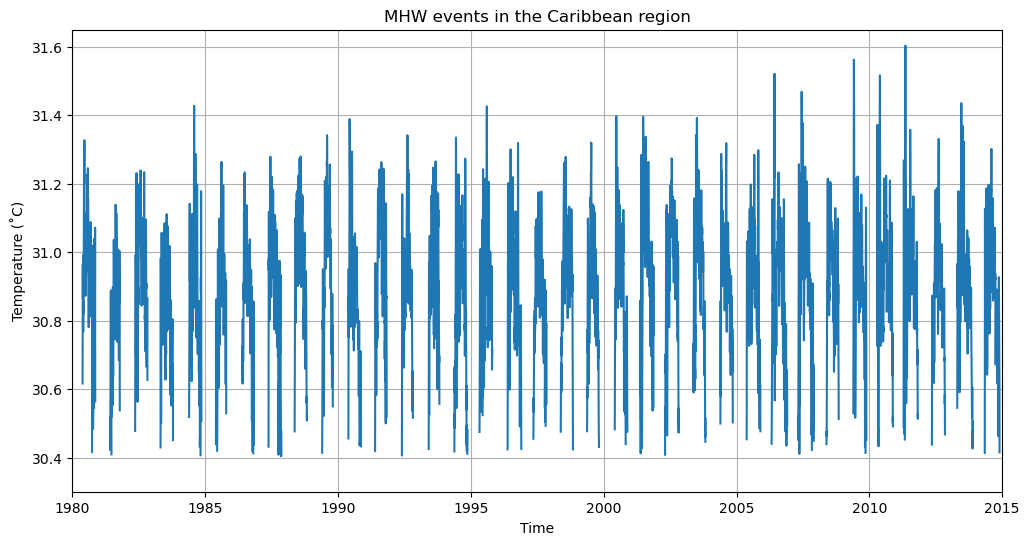

In [22]:
ticks = np.append(mhws.time[0::5*365].values,mhws.time[-1].values)
tick_labels = ['1980', '1985', '1990', '1995', '2000', '2005', '2010', '2015']

time_series.plot()
plt.ylim(30.3, 31.65)
plt.xlim(csst.time[0].values, csst.time[-1].values)
plt.xticks(ticks, tick_labels)
plt.xlabel('Time')
plt.ylabel('Temperature (˚C)')
plt.title('MHW events in the Caribbean region')
plt.grid();

In [23]:
land_mask = ds.tos.sel(**carib).isel(time=0).isnull()

In [24]:
def plot_mhw(time):    
    land_mask.plot(cmap='Greys', add_colorbar=False)
    mhws.sel(time=time).where(~land_mask).squeeze().plot.contourf(levels=np.arange(27, 31, .2),
                                                                  cmap=cm.cm.thermal, vmin=25)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Extreme SST on {time}')
    plt.grid();

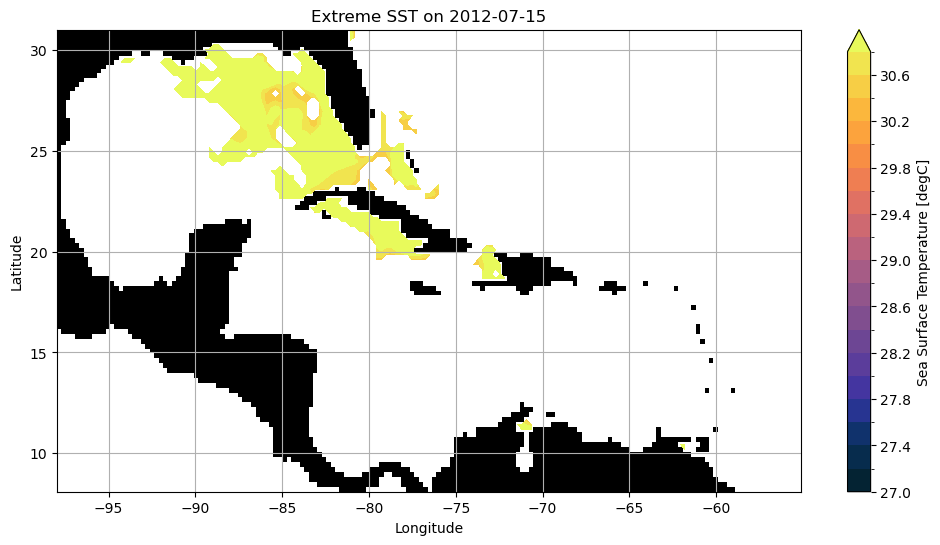

In [25]:
#play around with different dates to see spatial extent of some of these extreme ssts
time = '2012-07-15'
plot_mhw(time)

## El Niño 3.4 idnex

This section is borrowed from one of Project Pythia's [Intro to Pandas](https://foundations.projectpythia.org/core/pandas/pandas.html#quick-plots-of-your-data) notebook

In [26]:
! pip install pythia_datasets

In [27]:
import pandas as pd
from pythia_datasets import DATASETS

In [28]:
filepath = DATASETS.fetch('enso_data.csv')

In [29]:
df = pd.read_csv(filepath, index_col=0, parse_dates=True)
df

,Nino12,Nino12anom,Nino3,Nino3anom,Nino4,Nino4anom,Nino34,Nino34anom
datetime,,,,,,,,
1982-01-01,24.29,-0.17,25.87,0.24,28.30,0.00,26.72,0.15
1982-02-01,25.49,-0.58,26.38,0.01,28.21,0.11,26.70,-0.02
1982-03-01,25.21,-1.31,26.98,-0.16,28.41,0.22,27.20,-0.02
1982-04-01,24.50,-0.97,27.68,0.18,28.92,0.42,28.02,0.24
1982-05-01,23.97,-0.23,27.79,0.71,29.49,0.70,28.54,0.69
...,...,...,...,...,...,...,...,...
2020-12-01,22.16,-0.60,24.38,-0.83,27.65,-0.95,25.53,-1.12
2021-01-01,23.89,-0.64,25.06,-0.55,27.10,-1.25,25.58,-0.99
2021-02-01,25.55,-0.66,25.80,-0.57,27.20,-1.00,25.81,-0.92


In [30]:
oni_time_unmatched = df['Nino34anom']
oni_pd = oni_time_unmatched.loc['1982':'2014']
oni = oni_pd.to_xarray()

In [31]:
mhws_cut = mhws.sel(time=slice('1982', '2015')).resample(time='MS').mean('time')

In [32]:
mhws_cut.shape

(396, 98, 169)

In [33]:
oni.shape

(396,)

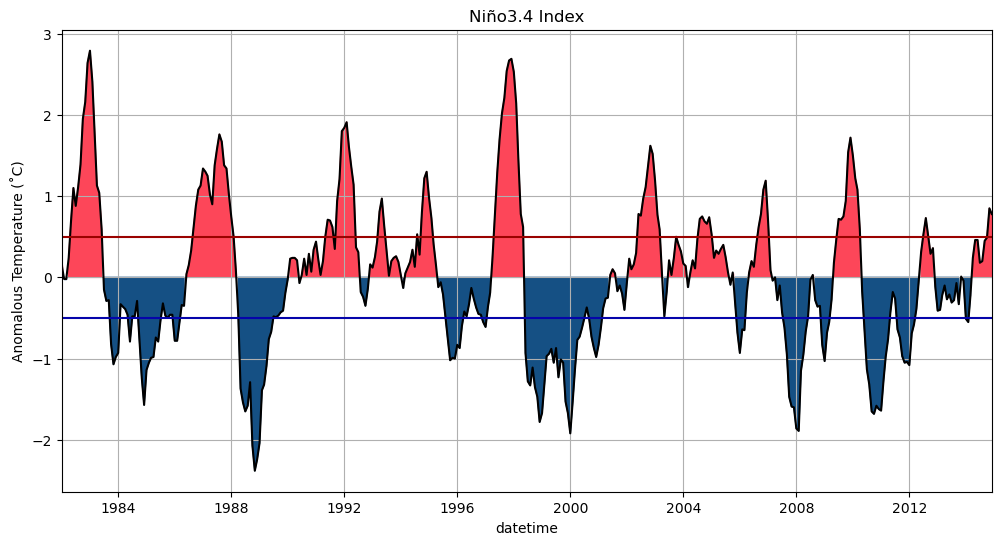

In [34]:
oni.plot(color='k')
plt.fill_between(oni.datetime, oni.where(oni>=0), color='xkcd:watermelon')
plt.fill_between(oni.datetime, oni.where(oni<=0), color='xkcd:light navy')
plt.hlines(0.5, xmin=oni.datetime[0], xmax=oni.datetime[-1], color='xkcd:deep red')
plt.hlines(-0.5, xmin=oni.datetime[0], xmax=oni.datetime[-1], color='xkcd:royal blue')
plt.xlim(oni.datetime[0], oni.datetime[-1])
plt.grid()
plt.ylabel('Anomalous Temperature (˚C)')
plt.title('Niño3.4 Index');

In [35]:
#match oni time dim/coord to mhws_cut obj
oni_nc = xr.DataArray(data=oni.values, coords={'time':mhws_cut.time}, name='Nino34anom')

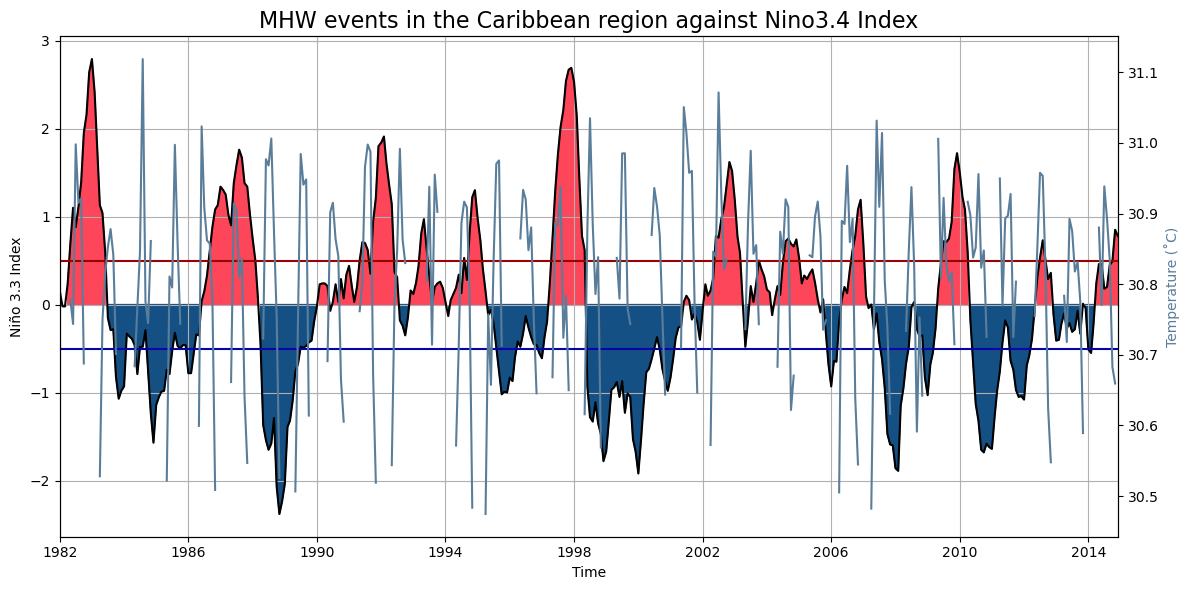

In [39]:
fig, ax1 = plt.subplots()

ticks = mhws_cut.time[0::4*12].values
tick_labels = ['1982', '1986', '1990', '1994', '1998', '2002', '2006', '2010', '2014']


ax1.set_xlabel('Time')
ax1.tick_params(axis='y')
ax1.set_ylabel('Niño 3.3 Index', color='k')  # we already handled the x-label with ax1
ax1.plot(oni_nc.time, oni.values, color='k')
ax1.tick_params(axis='y', labelcolor='k')
ax1.fill_between(oni_nc.time.values, oni_nc.where(oni_nc>=0), color='xkcd:watermelon')
ax1.fill_between(oni_nc.time.values, oni_nc.where(oni_nc<=0), color='xkcd:light navy')
ax1.hlines(0.5, xmin=oni_nc.time[0].values, xmax=oni_nc.time[-1].values, color='xkcd:deep red')
ax1.hlines(-0.5, xmin=oni_nc.time[0].values, xmax=oni_nc.time[-1].values, color='xkcd:royal blue')
ax1.grid()
ax1.set_xlim(mhws_cut.time[0].values, mhws_cut.time[-1].values)
ax1.set_xticks(ticks, tick_labels)
ax1.set_title('MHW events in the Caribbean region against Nino3.4 Index', fontsize=16)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis
ax2.set_ylabel('Temperature (˚C)', color='xkcd:steel blue')#, rotation=270)
ax2.plot(mhws_cut.time, mhws_cut.mean(['x', 'y']), color='xkcd:steel blue')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

---

## Summary
Add one final `---` marking the end of your body of content, and then conclude with a brief single paragraph summarizing at a high level the key pieces that were learned and how they tied to your objectives. Look to reiterate what the most important takeaways were.

### What's next?
Let Jupyter book tie this to the next (sequential) piece of content that people could move on to down below and in the sidebar. However, if this page uniquely enables your reader to tackle other nonsequential concepts throughout this book, or even external content, link to it here!

## Resources and references
Finally, be rigorous in your citations and references as necessary. Give credit where credit is due. Also, feel free to link to relevant external material, further reading, documentation, etc. Then you're done! Give yourself a quick review, a high five, and send us a pull request. A few final notes:
 - `Kernel > Restart Kernel and Run All Cells...` to confirm that your notebook will cleanly run from start to finish
 - `Kernel > Restart Kernel and Clear All Outputs...` before committing your notebook, our machines will do the heavy lifting
 - Take credit! Provide author contact information if you'd like; if so, consider adding information here at the bottom of your notebook
 - Give credit! Attribute appropriate authorship for referenced code, information, images, etc.
 - Only include what you're legally allowed: **no copyright infringement or plagiarism**
 
Thank you for your contribution!